In [239]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [150]:
data = np.load('data.npz')

X1_obs = data['X1_obs']
X1_h1 = data['X1_h1']
X1_h2 = data['X1_h2']
X1_act = data['X1_act']
X2_obs = data['X2_obs']
X2_h1 = data['X2_h1']
X2_h2 = data['X2_h2']
X2_act = data['X2_act']
X3_obs = data['X3_obs']
X3_h1 = data['X3_h1']
X3_h2 = data['X3_h2']
X3_act = data['X3_act']
y1 = data['y1']
y2 = data['y2']
y3 = data['y3']

In [265]:
def train_and_test(X, y):
    # only episodes where the other agent covers just one landmark 
    idx = np.where(np.sum(y, axis=-1) == 1)[0]
    X = X[idx]
    y = y[idx]

    # duplicate the last step landmark data over all episode timesteps
    y = y[:, np.newaxis, :]
    y = y.repeat(X.shape[1], axis=1)
    y = np.argmax(y, axis=-1) # convert one-hot vector into indices

    # split into training and test episodes (NB! this is done at episode level!)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

    # use only middle 5 steps for testing
    X_test = X_test[:, 10:15]
    y_test = y_test[:, 10:15]
    
    # get rid of the episode dimension
    X_train = X_train.reshape((-1, X.shape[2]))
    X_test = X_test.reshape((-1, X.shape[2]))
    y_train = y_train.reshape((-1,))
    y_test = y_test.reshape((-1,))

    # normalize input features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train linear classifier
    #clf = SVC(kernel='linear', C=1, cache_size=1000)
    #clf = LinearSVC(C=1)
    #clf = SGDClassifier()
    #clf = LinearDiscriminantAnalysis()
    clf = MLPClassifier(hidden_layer_sizes=tuple(), solver='adam')
    clf.fit(X_train, y_train)

    # calculate training and test accuracy
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [235]:
acc = np.empty((3, 3, 4, 2))
for i in range(3):
    for j in range(3):
        acc[i, j, 0] = train_and_test(data['X%d_obs' % (i + 1)], data['y%d' % (j + 1)])
        acc[i, j, 1] = train_and_test(data['X%d_h1' % (i + 1)], data['y%d' % (j + 1)])
        acc[i, j, 2] = train_and_test(data['X%d_h2' % (i + 1)], data['y%d' % (j + 1)])
        acc[i, j, 3] = train_and_test(data['X%d_act' % (i + 1)], data['y%d' % (j + 1)])

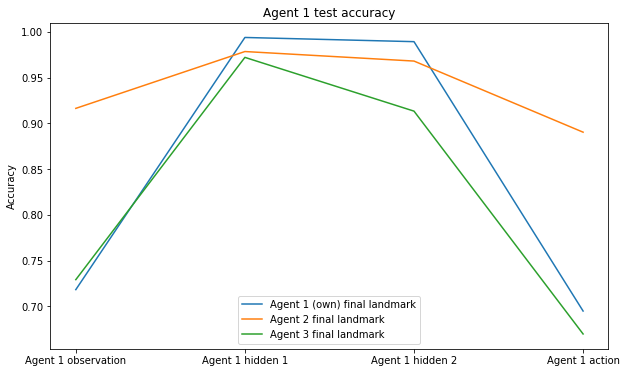

In [262]:
plt.figure(figsize=(10, 6))
plt.plot(acc[0, :, :, 1].T)
plt.ylabel('Accuracy')
#plt.xlabel('Features')
plt.title('Agent 1 test accuracy')
plt.xticks(range(4), ['Agent 1 observation', 'Agent 1 hidden 1', 'Agent 1 hidden 2', 'Agent 1 action'])
plt.legend(['Agent 1 (own) final landmark', 'Agent 2 final landmark', 'Agent 3 final landmark'], loc='lower center')

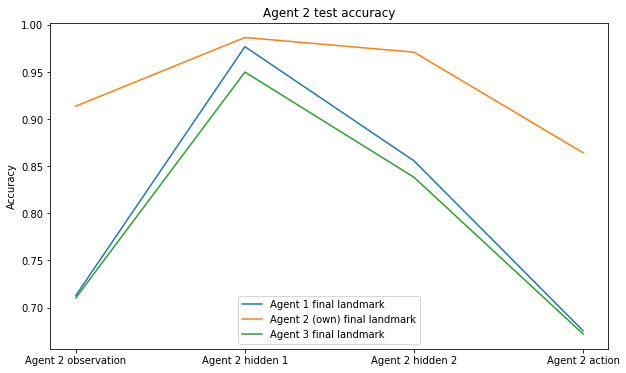

In [263]:
plt.figure(figsize=(10, 6))
plt.plot(acc[1, :, :, 1].T)
plt.ylabel('Accuracy')
#plt.xlabel('Features')
plt.title('Agent 2 test accuracy')
plt.xticks(range(4), ['Agent 2 observation', 'Agent 2 hidden 1', 'Agent 2 hidden 2', 'Agent 2 action'])
plt.legend(['Agent 1 final landmark', 'Agent 2 (own) final landmark', 'Agent 3 final landmark'], loc='lower center')

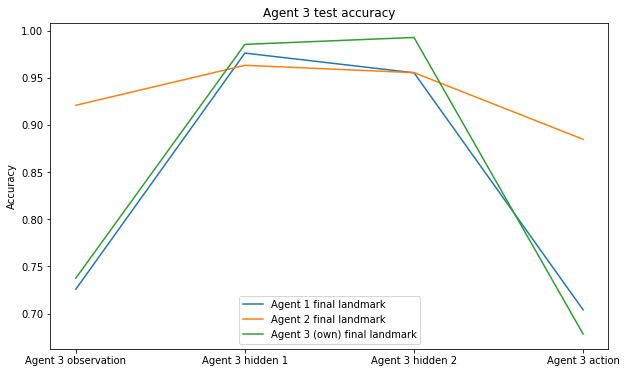

In [264]:
plt.figure(figsize=(10, 6))
plt.plot(acc[2, :, :, 1].T)
plt.ylabel('Accuracy')
#plt.xlabel('Features')
plt.title('Agent 3 test accuracy')
plt.xticks(range(4), ['Agent 3 observation', 'Agent 3 hidden 1', 'Agent 3 hidden 2', 'Agent 3 action'])
plt.legend(['Agent 1 final landmark', 'Agent 2 final landmark', 'Agent 3 (own) final landmark'], loc='lower center')

In [282]:
def train_and_test_timestep(X, y, t):
    # only episodes where the other agent covers just one landmark 
    idx = np.where(np.sum(y, axis=-1) == 1)[0]
    X = X[idx, t]
    y = y[idx]

    # convert one-hot vector into indices
    y = np.argmax(y, axis=-1)

    # split into training and test episodes (NB! this is done at episode level!)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

    # normalize input features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train linear classifier
    #clf = SVC(kernel='linear', C=1, cache_size=1000)
    #clf = LinearSVC(C=1)
    #clf = SGDClassifier()
    #clf = LinearDiscriminantAnalysis()
    clf = MLPClassifier(hidden_layer_sizes=tuple(), solver='adam')
    clf.fit(X_train, y_train)

    # calculate training and test accuracy
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [283]:
acc = np.empty((3, 3, 25, 4, 2))
for i in range(3):
    for j in range(3):
        for t in range(25):
            print(i, j, t, end='')
            acc[i, j, t, 0] = train_and_test_timestep(data['X%d_obs' % (i + 1)], data['y%d' % (j + 1)], t)
            acc[i, j, t, 1] = train_and_test_timestep(data['X%d_h1' % (i + 1)], data['y%d' % (j + 1)], t)
            acc[i, j, t, 2] = train_and_test_timestep(data['X%d_h2' % (i + 1)], data['y%d' % (j + 1)], t)
            acc[i, j, t, 3] = train_and_test_timestep(data['X%d_act' % (i + 1)], data['y%d' % (j + 1)], t)
            print(acc[i, j, t, :, 1])

0 0 0

/home/tambet/.conda/envs/multi/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.66712517 0.88033012 0.85969739 0.67262724]
0 0 1[0.68500688 0.91471802 0.90921596 0.70563961]
0 0 2[0.67537827 0.91746905 0.93259972 0.68913343]
0 0 3[0.7221458  0.94497937 0.94497937 0.66850069]
0 0 4[0.696011   0.92572215 0.94085282 0.70013755]
0 0 5[0.70701513 0.9394773  0.96011004 0.69325997]
0 0 6[0.73177442 0.95873453 0.97661623 0.68913343]
0 0 7[0.71114168 0.97799175 0.97111417 0.67262724]
0 0 8[0.69325997 0.9738652  0.97661623 0.68913343]
0 0 9[0.696011   0.97936726 0.98486933 0.69325997]
0 0 10[0.7303989  0.98624484 0.98211829 0.70151307]
0 0 11[0.7221458  0.98762036 0.98899587 0.6698762 ]
0 0 12[0.73452545 0.98349381 0.99037139 0.67400275]
0 0 13[0.72902338 0.98762036 0.99312242 0.67400275]
0 0 14[0.72352132 0.99174691 0.98899587 0.6781293 ]
0 0 15[0.7221458  0.98899587 0.98899587 0.65337001]
0 0 16[0.71389271 0.99587345 0.99312242 0.68775791]
0 0 17[0.72627235 0.99312242 0.99312242 0.69188446]
0 0 18[0.72352132 0.99724897 0.98899587 0.67675378]
0 0 19[0.68088033 0.9944979

2 0 9[0.73177442 0.9656121  0.95598349 0.68088033]
2 0 10[0.68775791 0.96011004 0.94635488 0.70013755]
2 0 11[0.68775791 0.98486933 0.96011004 0.67537827]
2 0 12[0.72902338 0.98349381 0.94497937 0.69463549]
2 0 13[0.71389271 0.97936726 0.94635488 0.68775791]
2 0 14[0.69463549 0.98074278 0.96423659 0.6437414 ]
2 0 15[0.72627235 0.99174691 0.94910591 0.69188446]
2 0 16[0.70701513 0.99174691 0.95873453 0.68225585]
2 0 17[0.74140303 0.98349381 0.96011004 0.71526823]
2 0 18[0.72627235 0.98762036 0.95873453 0.66712517]
2 0 19[0.70976616 0.98349381 0.9656121  0.67125172]
2 0 20[0.70701513 0.98074278 0.96011004 0.69738652]
2 0 21[0.7303989  0.99037139 0.95735901 0.68225585]
2 0 22[0.73590096 0.99312242 0.96011004 0.69738652]
2 0 23[0.70013755 0.98899587 0.96148556 0.68775791]
2 0 24[0.71389271 0.98624484 0.95873453 0.68638239]
2 1 0[0.890625   0.89732143 0.875      0.88616071]
2 1 1[0.89732143 0.89508929 0.90178571 0.89732143]
2 1 2[0.890625   0.91964286 0.859375   0.90625   ]
2 1 3[0.89285714

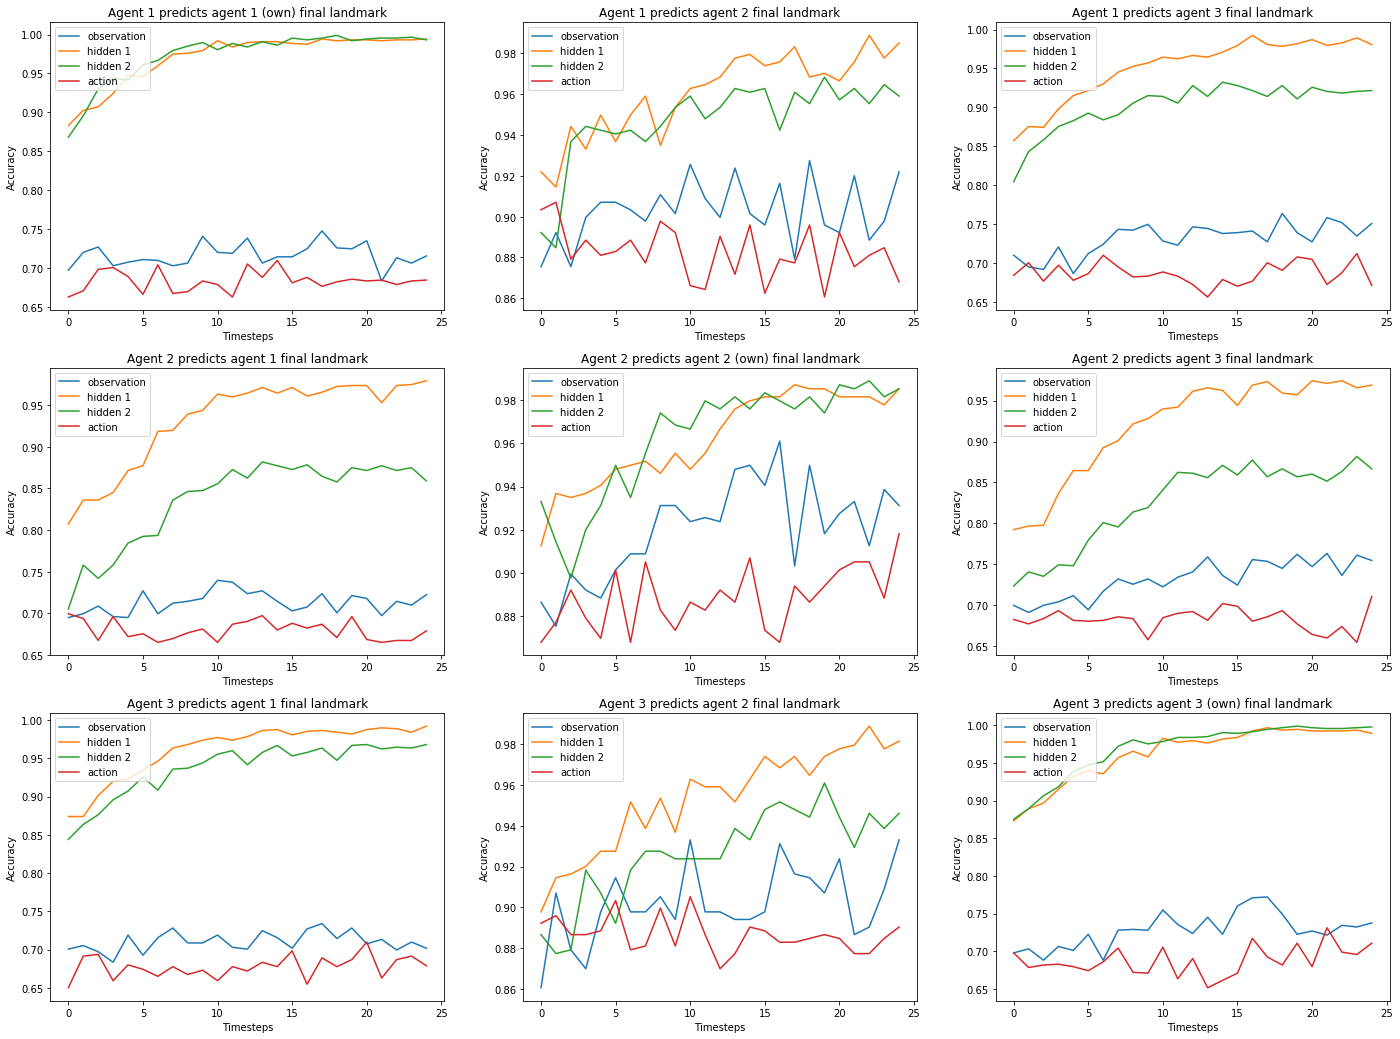

In [281]:
plt.figure(figsize=(24, 18))
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i*3 + j + 1)
        plt.plot(acc[i, j, :, :, 1])
        plt.ylabel('Accuracy')
        plt.xlabel('Timesteps')
        plt.title('Agent %d predicts agent %d%s final landmark' % (i + 1, j + 1, ' (own)' if i == j else ''))
        plt.legend(['observation', 'hidden 1', 'hidden 2', 'action'], loc='upper left')